# Essay Writer

Here's a schema describing what we're going to build.

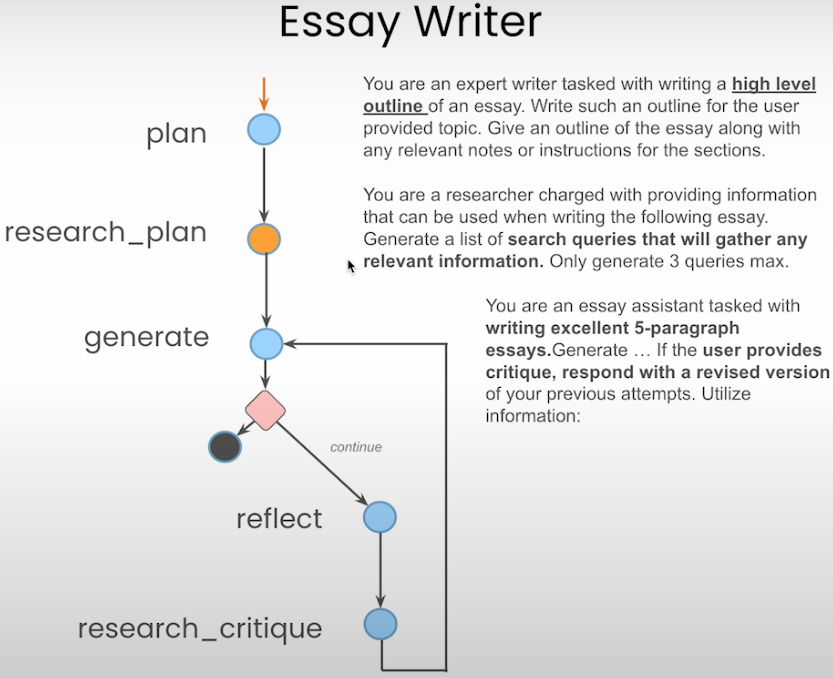

# Setup

In [1]:
from dotenv import load_dotenv

In [2]:
_ = load_dotenv()

# Global Imports

In [3]:
import operator
from typing import Annotated, List, TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage, AnyMessage, ChatMessage, HumanMessage, SystemMessage

In [4]:
memory = SqliteSaver.from_conn_string(":memory:")

# Code

In [5]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [6]:
from langchain_openai import ChatOpenAI

In [7]:
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [8]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [9]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays. \
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attemps. \
Utilize all the information below as needed:

------

{content}"""

In [10]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [11]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

In [12]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that willgather any relevant information. Only generate 3 queries max."""

In [13]:
from langchain_core.pydantic_v1 import BaseModel

In [14]:
class Queries(BaseModel):
    queries: List[str]

In [15]:
import os

from tavily import TavilyClient

In [16]:
tavily = TavilyClient(api_key = os.getenv("TAVILY_API_KEY"))

## Nodes

In [17]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}  # Update the 'plan'

In [18]:
def research_plan_node(state: AgentState):
    # Define queries as a Queries pydantic object with this syntax
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    # Look if there's something inside state['content']
    # If not, initialize it to an empty list
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}  # Update the 'content' 

In [19]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1  # Shouldn't this be 0?
    }

In [20]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [21]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [22]:
def should_continue(state: AgentState):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

# Graph

In [23]:
builder = StateGraph(AgentState)

In [24]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [25]:
builder.set_entry_point("planner")

In [26]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
    # key is the return value of the node, value is the next node
)

In [27]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [28]:
graph = builder.compile(checkpointer=memory)

In [29]:
from IPython.display import Image

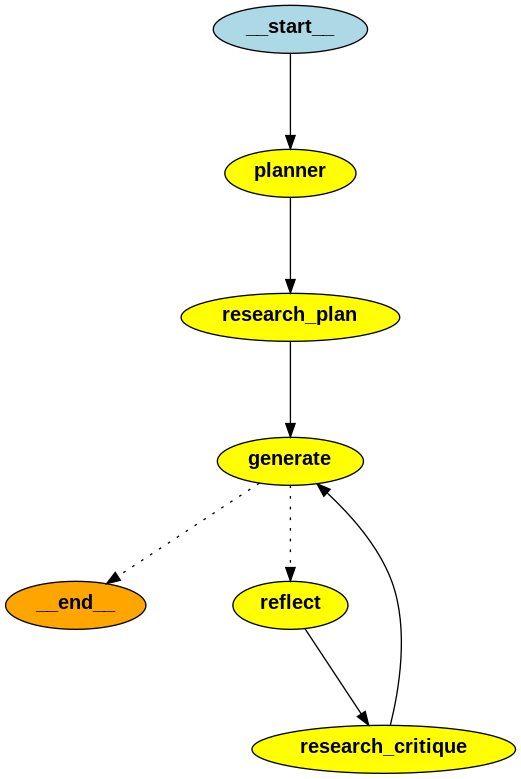

In [30]:
Image(graph.get_graph().draw_png())

# Thread

In [31]:
from rich import print as rprint

In [32]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    "task": "What are the fundamentals of Agile Scrum method?",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    rprint(s)

{
    'planner': {
        'plan': 'I. Introduction\n    A. Definition of Agile Scrum method\n    B. Importance of Agile Scrum in 
project management\n\nII. Origins of Agile Scrum\n    A. History of Agile methodology\n    B. Evolution of Scrum 
framework\n\nIII. Key Principles of Agile Scrum\n    A. Iterative and incremental development\n    B. 
Self-organizing teams\n    C. Collaboration and communication\n    D. Adaptability and flexibility\n\nIV. Roles in 
Agile Scrum\n    A. Scrum Master\n    B. Product Owner\n    C. Development Team\n\nV. Agile Scrum Framework\n    A.
Sprints\n    B. Daily Stand-ups\n    C. Sprint Review\n    D. Sprint Retrospective\n\nVI. Benefits of Agile Scrum\n
A. Increased productivity\n    B. Enhanced team collaboration\n    C. Improved product quality\n    D. Customer 
satisfaction\n\nVII. Challenges of Agile Scrum\n    A. Resistance to change\n    B. Lack of experience with Agile 
practices\n    C. Time and resource constraints\n\nVIII. Conclusion\n    A. Recap of Agile Scrum fundamentals\n    
B. Future outlook for Agile Scrum in project management'
    }
}

{
    'research_plan': {
        'content': [
            'The online course includes: Take an unproctored 40-question online exam. Answer 30 out of 40 questions
correctly and get recognized as "SCRUM Fundamentals Certified" by SCRUMstudy ™. Your name will be added to the 
SCRUMstudy ™ Certification Registry. SCRUMstudy\'s \'Scrum Fundamentals Certified\' is a free Online course to 
understand Scrum ...',
            'Scrum is the most widely used and popular agile framework. The term "Agile" describes a specific set 
of foundational principles and values for organizing and managing complex work based on the Agile Manifesto.The 
creators of the manifesto also considered the words "lightweight" and "adaptive," and eventually all agreed that 
"agile" was the most effective term for their purposes.',
            "Trello\nVisual project management\nView all products\nMarketplace\nConnect thousands of apps and 
integrations for all your Atlassian products\nWHAT’S NEW\nCompass\nDeveloper Experience Platform\nJira Product 
Discovery\nPrioritization and roadmapping\nView all\nYou might find helpful\nCloud Product Roadmap\nAtlassian 
Migration Program\nFeatured\nWork Management\nManage projects and align goals across all teams to achieve 
deliverables\nIT Service Management\nEnable dev, IT ops, and business teams to deliver great service at high 
velocity\nAgile & DevOps\nRun a world-class agile software organization from discovery to delivery and 
operations\nBY TEAM SIZE\nEnterprise\nSmall Business\nStartup\nNon-profit\nBY TEAM FUNCTION\nSoftware 
Development\nIT\nFinance\nMarketing\nHR\nBY INDUSTRY\nRetail\nTelecommunications\nProfessional 
Services\nGovernment\nWhat's new\nAtlassian Together\nGet Atlassian work management products in one convenient 
package for enterprise teams.\n Learn more\nYou might find helpful\nAtlassian Trust & Security\nCustomer Case 
Studies\nLearn\nAtlassian University\nAtlassian Playbook\nProduct Documentation\nDeveloper 
Resources\nSupport\nAtlassian Community\nAtlassian Support\nAtlassian Migration Program\nEnterprise 
Services\nPartner Support\nPurchasing & Licensing\nConnect\nAbout us\nCareers\nWork Life Blog\nEvents\nSupport for 
Server products ends February 15, 2024\nWith end of support for our Server products fast approaching, create a 
winning plan for your Cloud migration with the Atlassian Migration Program.\n How to Ensure Transparency in 
Scrum\nTransparency manifests in various facets of Scrum, including:\nLeveraging Jira's Scrum Template and 
Confluence's sprint planning template can help your team streamline documentation, facilitate effective 
communication, and maintain the three pillars of Scrum.\n Featured\nJira Software\nProject and issue 
tracking\nConfluence\nContent collaboration\nJira Service Management\nHigh-velocity ITSM\n Let’s take a look at how
teams can implement adaptation and how Jira can assist in visualizing and managing these stages:\nThe benefits of 
adaptation are multifaceted, encompassing alignment with changing demands, a culture of innovation, the product 
development process, early issue detection, and resource optimization.",
            'The use of the word\xa0 reflects the fact that agile “grew up” in software development, meaning that 
many of those who originally participated in the creation of the Agile Manifesto were in the software field.\xa0  
About Us\nLearn About Scrum\nTraining Details\nCourses by Accountability (Role)\nCourses\nCertifications\nPractice 
with Open Assessments\nGeneral Resources\nLearning Paths\nResources by Type (most popular)\nAbout Us\nLearn About 
Scrum\nTraining Details\nCourses by Accountability (Role)\nCourses\nCertifications\nPractice with Open 
Assessments\nGeneral Resources\nLearning Paths\nResources by Type (most popular)\n The waterfall team envisions 
only the final product and delivers it in silos by working on systems that will be part of the final delivery, such
as the tires, the frame and finally, the car.\xa0  The lef

{
    'generate': {
        'draft': '**Revised Essay:**\n\nAgile Scrum is a methodology that has revolutionized project management by 
emphasizing adaptability, collaboration, and iterative development. This essay will delve into the fundamentals of 
the Agile Scrum method, exploring its origins, key principles, roles, framework, benefits, challenges, and future 
outlook in project management.\n\nThe Agile Scrum method originated from the Agile methodology, which was developed
as a response to the traditional waterfall approach to project management. The evolution of the Scrum framework 
further refined Agile practices, focusing on flexibility and continuous improvement.\n\nKey principles of Agile 
Scrum include iterative and incremental development, where projects are broken down into manageable increments, 
self-organizing teams that collaborate closely, and adaptability and flexibility to respond to changing 
requirements effectively.\n\nRoles in Agile Scrum are crucial for its success. The Scrum Master facilitates the 
Scrum process, the Product Owner represents the stakeholders and ensures the team delivers value, and the 
Development Team is responsible for creating the product increment.\n\nThe Agile Scrum framework is structured 
around Sprints, which are time-boxed iterations for completing work, Daily Stand-ups for team synchronization, 
Sprint Review for stakeholder feedback, and Sprint Retrospective for continuous improvement.\n\nThe benefits of 
Agile Scrum are numerous, including increased productivity due to focused work increments, enhanced team 
collaboration through regular communication, improved product quality from continuous feedback, and higher customer
satisfaction from delivering value early and often.\n\nHowever, Agile Scrum also presents challenges such as 
resistance to change from traditional project management practices, lack of experience with Agile methodologies, 
and constraints in time and resources that may hinder its implementation.\n\nIn conclusion, Agile Scrum has become 
a cornerstone in modern project management due to its emphasis on adaptability, collaboration, and customer value. 
As organizations continue to adopt Agile practices, the future outlook for Agile Scrum in project management is 
promising, with its principles and frameworks evolving to meet the dynamic demands of the industry.',
        'revision_number': 2
    }
}

{
    'reflect': {
        'critique': "**Critique:**\n\nYour essay provides a solid overview of Agile Scrum methodology, covering its
origins, key principles, roles, framework, benefits, challenges, and future outlook. However, there are areas where
you can enhance the depth and clarity of your discussion.\n\n**Recommendations:**\n\n1. **Introduction:**\n   - 
Consider adding a more engaging hook to draw in the reader's attention. You could start with a relevant statistic, 
quote, or real-world example to highlight the significance of Agile Scrum in project management.\n\n2. **Key 
Principles:**\n   - While you briefly touch upon the key principles of Agile Scrum, consider expanding on each 
principle with examples or case studies to illustrate how they are applied in practice. This will provide a clearer
understanding for readers who may be new to the concept.\n\n3. **Roles:**\n   - Provide more details on the 
responsibilities of each role in Agile Scrum. Explain how the Scrum Master, Product Owner, and Development Team 
collaborate and interact to ensure project success. Additionally, discuss the importance of cross-functional teams 
in Agile Scrum.\n\n4. **Framework:**\n   - Elaborate on the different ceremonies within the Agile Scrum framework, 
such as Sprint Planning, Backlog Refinement, and Definition of Done. Explain how these ceremonies contribute to 
project transparency, collaboration, and continuous improvement.\n\n5. **Benefits and Challenges:**\n   - While you
list the benefits and challenges of Agile Scrum, consider providing specific examples or case studies to support 
your points. This will add credibility to your arguments and help readers visualize the practical implications of 
adopting Agile Scrum.\n\n6. **Conclusion:**\n   - Strengthen your conclusion by summarizing the key takeaways from 
your essay and reiterating the importance of Agile Scrum in modern project management. Consider ending with a 
thought-provoking statement or a call to action to inspire further exploration of the topic.\n\n7. **Length and 
Depth:**\n   - Expand on each section of your essay to provide a more comprehensive analysis of Agile Scrum 
methodology. Consider adding real-world examples, best practices, and tips for overcoming common challenges faced 
when implementing Agile Scrum in projects.\n\n8. **Style and Tone:**\n   - Maintain a formal and professional tone 
throughout your essay. Ensure that your writing is clear, concise, and free of any grammatical errors or jargon 
that may confuse readers. Use transition words to improve the flow between paragraphs and sections.\n\nBy 
incorporating these recommendations, you can enhance the quality and depth of your essay on Agile Scrum 
methodology, making it more informative and engaging for your audience."
    }
}

{
    'research_critique': {
        'content': [
            'The online course includes: Take an unproctored 40-question online exam. Answer 30 out of 40 questions
correctly and get recognized as "SCRUM Fundamentals Certified" by SCRUMstudy ™. Your name will be added to the 
SCRUMstudy ™ Certification Registry. SCRUMstudy\'s \'Scrum Fundamentals Certified\' is a free Online course to 
understand Scrum ...',
            'Scrum is the most widely used and popular agile framework. The term "Agile" describes a specific set 
of foundational principles and values for organizing and managing complex work based on the Agile Manifesto.The 
creators of the manifesto also considered the words "lightweight" and "adaptive," and eventually all agreed that 
"agile" was the most effective term for their purposes.',
            "Trello\nVisual project management\nView all products\nMarketplace\nConnect thousands of apps and 
integrations for all your Atlassian products\nWHAT’S NEW\nCompass\nDeveloper Experience Platform\nJira Product 
Discovery\nPrioritization and roadmapping\nView all\nYou might find helpful\nCloud Product Roadmap\nAtlassian 
Migration Program\nFeatured\nWork Management\nManage projects and align goals across all teams to achieve 
deliverables\nIT Service Management\nEnable dev, IT ops, and business teams to deliver great service at high 
velocity\nAgile & DevOps\nRun a world-class agile software organization from discovery to delivery and 
operations\nBY TEAM SIZE\nEnterprise\nSmall Business\nStartup\nNon-profit\nBY TEAM FUNCTION\nSoftware 
Development\nIT\nFinance\nMarketing\nHR\nBY INDUSTRY\nRetail\nTelecommunications\nProfessional 
Services\nGovernment\nWhat's new\nAtlassian Together\nGet Atlassian work management products in one convenient 
package for enterprise teams.\n Learn more\nYou might find helpful\nAtlassian Trust & Security\nCustomer Case 
Studies\nLearn\nAtlassian University\nAtlassian Playbook\nProduct Documentation\nDeveloper 
Resources\nSupport\nAtlassian Community\nAtlassian Support\nAtlassian Migration Program\nEnterprise 
Services\nPartner Support\nPurchasing & Licensing\nConnect\nAbout us\nCareers\nWork Life Blog\nEvents\nSupport for 
Server products ends February 15, 2024\nWith end of support for our Server products fast approaching, create a 
winning plan for your Cloud migration with the Atlassian Migration Program.\n How to Ensure Transparency in 
Scrum\nTransparency manifests in various facets of Scrum, including:\nLeveraging Jira's Scrum Template and 
Confluence's sprint planning template can help your team streamline documentation, facilitate effective 
communication, and maintain the three pillars of Scrum.\n Featured\nJira Software\nProject and issue 
tracking\nConfluence\nContent collaboration\nJira Service Management\nHigh-velocity ITSM\n Let’s take a look at how
teams can implement adaptation and how Jira can assist in visualizing and managing these stages:\nThe benefits of 
adaptation are multifaceted, encompassing alignment with changing demands, a culture of innovation, the product 
development process, early issue detection, and resource optimization.",
            'The use of the word\xa0 reflects the fact that agile “grew up” in software development, meaning that 
many of those who originally participated in the creation of the Agile Manifesto were in the software field.\xa0  
About Us\nLearn About Scrum\nTraining Details\nCourses by Accountability (Role)\nCourses\nCertifications\nPractice 
with Open Assessments\nGeneral Resources\nLearning Paths\nResources by Type (most popular)\nAbout Us\nLearn About 
Scrum\nTraining Details\nCourses by Accountability (Role)\nCourses\nCertifications\nPractice with Open 
Assessments\nGeneral Resources\nLearning Paths\nResources by Type (most popular)\n The waterfall team envisions 
only the final product and delivers it in silos by working on systems that will be part of the final delivery, such
as the tires, the frame and finally, the car.\xa0  The

{
    'generate': {
        'draft': '**Title: Understanding the Fundamentals of Agile Scrum Method**\n\nI. Introduction\nA. The Agile 
Scrum method is a project management framework that emphasizes iterative and incremental development.\nB. Agile 
Scrum is crucial in project management for its adaptability, flexibility, and focus on delivering value to 
customers efficiently.\n\nII. Origins of Agile Scrum\nA. Agile methodology traces back to the early 2000s as a 
response to traditional, rigid project management practices.\nB. The Scrum framework evolved as a popular agile 
approach, emphasizing collaboration, adaptability, and continuous improvement.\n\nIII. Key Principles of Agile 
Scrum\nA. Iterative and incremental development allows for the delivery of working software in short cycles.\nB. 
Self-organizing teams promote autonomy and accountability, enhancing productivity and creativity.\nC. Collaboration
and communication are prioritized to ensure transparency and alignment within the team.\nD. Adaptability and 
flexibility enable teams to respond to change and deliver value effectively.\n\nIV. Roles in Agile Scrum\nA. The 
Scrum Master facilitates the Scrum process, removes impediments, and ensures adherence to Scrum principles.\nB. The
Product Owner represents the stakeholders, prioritizes the product backlog, and ensures the team delivers 
value.\nC. The Development Team is responsible for delivering increments of work during each sprint, ensuring 
high-quality outcomes.\n\nV. Agile Scrum Framework\nA. Sprints are time-boxed iterations where the team completes a
set amount of work.\nB. Daily Stand-ups are short meetings where team members discuss progress, plan for the day, 
and address any impediments.\nC. Sprint Review involves showcasing the completed work to stakeholders for feedback 
and validation.\nD. Sprint Retrospective is a reflection meeting where the team identifies improvements for the 
next sprint.\n\nVI. Benefits of Agile Scrum\nA. Increased productivity due to focused work, continuous feedback, 
and iterative improvements.\nB. Enhanced team collaboration through regular communication, shared goals, and 
collective ownership.\nC. Improved product quality from frequent testing, early detection of issues, and customer 
feedback.\nD. Higher customer satisfaction by delivering valuable increments of work and adapting to changing 
requirements.\n\nVII. Challenges of Agile Scrum\nA. Resistance to change from team members accustomed to 
traditional project management approaches.\nB. Lack of experience with Agile practices may lead to difficulties in 
implementing Scrum effectively.\nC. Time and resource constraints can impact the adoption and success of Agile 
Scrum in organizations.\n\nVIII. Conclusion\nA. Recap of Agile Scrum fundamentals, highlighting its principles, 
roles, framework, benefits, and challenges.\nB. Future outlook for Agile Scrum in project management, emphasizing 
its continued relevance in a dynamic and fast-paced business environment.',
        'revision_number': 3
    }
}

In [36]:
from rich.console import Console
from rich.markdown import Markdown

In [37]:
console = Console()
markdown = Markdown("""
**Title: Understanding the Fundamentals of Agile Scrum Method**\n\nI. Introduction\nA. The Agile 
Scrum method is a project management framework that emphasizes iterative and incremental development.\nB. Agile 
Scrum is crucial in project management for its adaptability, flexibility, and focus on delivering value to 
customers efficiently.\n\nII. Origins of Agile Scrum\nA. Agile methodology traces back to the early 2000s as a 
response to traditional, rigid project management practices.\nB. The Scrum framework evolved as a popular agile 
approach, emphasizing collaboration, adaptability, and continuous improvement.\n\nIII. Key Principles of Agile 
Scrum\nA. Iterative and incremental development allows for the delivery of working software in short cycles.\nB. 
Self-organizing teams promote autonomy and accountability, enhancing productivity and creativity.\nC. Collaboration
and communication are prioritized to ensure transparency and alignment within the team.\nD. Adaptability and 
flexibility enable teams to respond to change and deliver value effectively.\n\nIV. Roles in Agile Scrum\nA. The 
Scrum Master facilitates the Scrum process, removes impediments, and ensures adherence to Scrum principles.\nB. The
Product Owner represents the stakeholders, prioritizes the product backlog, and ensures the team delivers 
value.\nC. The Development Team is responsible for delivering increments of work during each sprint, ensuring 
high-quality outcomes.\n\nV. Agile Scrum Framework\nA. Sprints are time-boxed iterations where the team completes a
set amount of work.\nB. Daily Stand-ups are short meetings where team members discuss progress, plan for the day, 
and address any impediments.\nC. Sprint Review involves showcasing the completed work to stakeholders for feedback 
and validation.\nD. Sprint Retrospective is a reflection meeting where the team identifies improvements for the 
next sprint.\n\nVI. Benefits of Agile Scrum\nA. Increased productivity due to focused work, continuous feedback, 
and iterative improvements.\nB. Enhanced team collaboration through regular communication, shared goals, and 
collective ownership.\nC. Improved product quality from frequent testing, early detection of issues, and customer 
feedback.\nD. Higher customer satisfaction by delivering valuable increments of work and adapting to changing 
requirements.\n\nVII. Challenges of Agile Scrum\nA. Resistance to change from team members accustomed to 
traditional project management approaches.\nB. Lack of experience with Agile practices may lead to difficulties in 
implementing Scrum effectively.\nC. Time and resource constraints can impact the adoption and success of Agile 
Scrum in organizations.\n\nVIII. Conclusion\nA. Recap of Agile Scrum fundamentals, highlighting its principles, 
roles, framework, benefits, and challenges.\nB. Future outlook for Agile Scrum in project management, emphasizing 
its continued relevance in a dynamic and fast-paced business environment.
""")
console.print(markdown)

Title: Understanding the Fundamentals of Agile Scrum Method                                                        

I. Introduction A. The Agile Scrum method is a project management framework that emphasizes iterative and          
incremental development. B. Agile Scrum is crucial in project management for its adaptability, flexibility, and    
focus on delivering value to customers efficiently.                                                                

II. Origins of Agile Scrum A. Agile methodology traces back to the early 2000s as a response to traditional, rigid 
project management practices. B. The Scrum framework evolved as a popular agile approach, emphasizing              
collaboration, adaptability, and continuous improvement.                                                           

III. Key Principles of Agile Scrum A. Iterative and incremental development allows for the delivery of working     
software in short cycles. B. Self-organizing teams promote autonomy and accountability, enhancing productivity and 
creativity. C. Collaboration and communication are prioritized to ensure transparency and alignment within the     
team. D. Adaptability and flexibility enable teams to respond to change and deliver value effectively.             

IV. Roles in Agile Scrum A. The Scrum Master facilitates the Scrum process, removes impediments, and ensures       
adherence to Scrum principles. B. The Product Owner represents the stakeholders, prioritizes the product backlog,  
and ensures the team delivers value. C. The Development Team is responsible for delivering increments of work      
during each sprint, ensuring high-quality outcomes.                                                                

V. Agile Scrum Framework A. Sprints are time-boxed iterations where the team completes a set amount of work. B.    
Daily Stand-ups are short meetings where team members discuss progress, plan for the day, and address any          
impediments. C. Sprint Review involves showcasing the completed work to stakeholders for feedback and validation.  
D. Sprint Retrospective is a reflection meeting where the team identifies improvements for the next sprint.        

VI. Benefits of Agile Scrum A. Increased productivity due to focused work, continuous feedback, and iterative      
improvements. B. Enhanced team collaboration through regular communication, shared goals, and collective ownership.
C. Improved product quality from frequent testing, early detection of issues, and customer feedback. D. Higher     
customer satisfaction by delivering valuable increments of work and adapting to changing requirements.             

VII. Challenges of Agile Scrum A. Resistance to change from team members accustomed to traditional project         
management approaches. B. Lack of experience with Agile practices may lead to difficulties in implementing Scrum   
effectively. C. Time and resource constraints can impact the adoption and success of Agile Scrum in organizations. 

VIII. Conclusion A. Recap of Agile Scrum fundamentals, highlighting its principles, roles, framework, benefits, and
challenges. B. Future outlook for Agile Scrum in project management, emphasizing its continued relevance in a      
dynamic and fast-paced business environment.

# Essay Writer Interface

In [33]:
import warnings

In [34]:
warnings.filterwarnings("ignore")

In [35]:
from helper import ewriter, writer_gui

ModuleNotFoundError: No module named 'helper'